## Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2


In [2]:
IMAGES_PATH = os.path.join('data1','images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## Annotate Images with LabelMe

In [7]:
!labelme

[INFO   ] font_manager:_rebuild:1337 - generated new fontManager
[INFO   ] font_manager:_rebuild:1337 - generated new fontManager
[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\HARDIK\.labelmerc
External WM_DESTROY received for  QWidgetWindow(0x2524bee1540, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x25245726fd0, name="MainWindowClassWindow")


## Review Dataset and Build Image Loading Function

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### Load Image into TF Data Pipeline

In [16]:
images = tf.data.Dataset.list_files('data1\\images\\*.jpg')


In [17]:
images.as_numpy_iterator().next()

b'data1\\images\\086a2cd9-07e2-11ed-b690-f5b5358f81c6.jpg'

In [18]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [19]:
images = images.map(load_image)

In [20]:
images.as_numpy_iterator().next()

array([[[ 77,  76,  72],
        [ 73,  74,  69],
        [ 71,  73,  68],
        ...,
        [156, 155, 151],
        [157, 156, 152],
        [158, 157, 153]],

       [[ 75,  74,  70],
        [ 74,  75,  70],
        [ 71,  76,  70],
        ...,
        [155, 154, 150],
        [155, 154, 150],
        [156, 155, 151]],

       [[ 74,  74,  72],
        [ 75,  77,  74],
        [ 75,  80,  76],
        ...,
        [154, 153, 149],
        [154, 153, 149],
        [155, 154, 150]],

       ...,

       [[119, 123, 109],
        [118, 122, 108],
        [118, 122, 108],
        ...,
        [122, 147, 141],
        [122, 147, 141],
        [123, 148, 142]],

       [[116, 122, 108],
        [116, 122, 108],
        [115, 121, 107],
        ...,
        [121, 148, 141],
        [122, 147, 141],
        [123, 148, 142]],

       [[115, 121, 107],
        [115, 121, 107],
        [115, 121, 107],
        ...,
        [120, 147, 140],
        [122, 147, 141],
        [122, 147, 141]]

In [21]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

## View Raw Images with Matplotlib

In [22]:
image_generator = images.batch(4).as_numpy_iterator()

In [26]:
plot_images = image_generator.next()

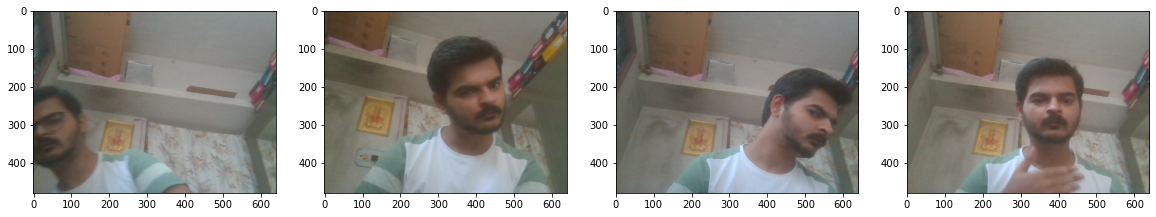

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## Partition Unaugmented Data

###  MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [29]:
90*.7 # 63 to train

62.99999999999999

In [30]:
90*.15 # 14 and 13 to test and val

13.5

## Move the Matching Labels

In [31]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data1', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data1','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data1',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

## Apply Image Augmentation on Images and Labels using Albumentations

### Setup Albumentations Transform Pipeline

In [32]:
import albumentations as alb

In [33]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### Load a Test Image and Annotation with OpenCV and JSON

In [34]:
img = cv2.imread(os.path.join('data1','train', 'images','824b2089-07e2-11ed-a887-f5b5358f81c6.jpg'))

In [35]:
img

array([[[ 68,  65,  60],
        [ 67,  64,  59],
        [ 66,  63,  58],
        ...,
        [152, 149, 145],
        [151, 147, 146],
        [150, 146, 145]],

       [[ 67,  64,  59],
        [ 66,  63,  58],
        [ 65,  62,  57],
        ...,
        [151, 148, 144],
        [150, 146, 145],
        [149, 145, 144]],

       [[ 68,  65,  57],
        [ 67,  64,  56],
        [ 66,  63,  55],
        ...,
        [149, 146, 142],
        [149, 146, 142],
        [149, 146, 142]],

       ...,

       [[101, 106, 107],
        [101, 107, 106],
        [102, 108, 107],
        ...,
        [140, 142, 130],
        [141, 140, 130],
        [143, 142, 132]],

       [[104, 107, 111],
        [103, 107, 108],
        [103, 107, 108],
        ...,
        [142, 145, 130],
        [146, 146, 134],
        [148, 148, 136]],

       [[105, 108, 112],
        [105, 108, 112],
        [105, 109, 110],
        ...,
        [144, 147, 132],
        [148, 148, 136],
        [152, 152, 140]]

In [36]:
with open(os.path.join('data1', 'train', 'labels', '824b2089-07e2-11ed-a887-f5b5358f81c6.json'), 'r') as f:
    label = json.load(f)

In [40]:
label['shapes'][0]['label']

'face'

## Extract Coordinates and Rescale to Match Image Resolution

In [41]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [42]:
coords

[280.12820512820514,
 129.74358974358975,
 455.51282051282055,
 337.94871794871796]

In [43]:
coords = list(np.divide(coords, [640,480,640,480]))

In [44]:
coords

[0.43770032051282054,
 0.27029914529914534,
 0.7117387820512822,
 0.7040598290598291]

## Apply Augmentations and View Results

In [45]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [48]:
augmented['image'].shape

(450, 450, 3)

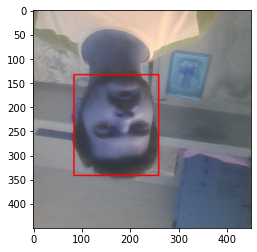

In [49]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)
plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

###  Run Augmentation Pipeline

In [52]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data1', partition, 'images')):
        img = cv2.imread(os.path.join('data1', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data1', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.8102964743589745, 0.8386752136752137, 0.5210336538461539, 0.4764957264957265, 'face'].


##  Load Augmented Images to Tensorflow Dataset

In [53]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [54]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [55]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [56]:
train_images.as_numpy_iterator().next()

array([[[0.52751225, 0.52751225, 0.48045343],
        [0.5487132 , 0.5408701 , 0.4898897 ],
        [0.5413603 , 0.5408701 , 0.48743874],
        ...,
        [0.52273285, 0.5815564 , 0.56194854],
        [0.5322304 , 0.5846201 , 0.57438725],
        [0.5382353 , 0.5852941 , 0.577451  ]],

       [[0.4970588 , 0.49577206, 0.45392156],
        [0.5407475 , 0.5329044 , 0.48541668],
        [0.54515934, 0.5373162 , 0.49025735],
        ...,
        [0.518076  , 0.5768995 , 0.5641544 ],
        [0.5210784 , 0.5803922 , 0.5686275 ],
        [0.53566176, 0.5882353 , 0.5786152 ]],

       [[0.5110907 , 0.499326  , 0.46403188],
        [0.54607844, 0.53431374, 0.4990196 ],
        [0.5416667 , 0.5416667 , 0.502451  ],
        ...,
        [0.5185049 , 0.57732844, 0.5577206 ],
        [0.525     , 0.5877451 , 0.57598037],
        [0.53137255, 0.5892157 , 0.58480394]],

       ...,

       [[0.49920344, 0.49920344, 0.4678309 ],
        [0.49797794, 0.49797794, 0.4666054 ],
        [0.49111518, 0

# Prepare Labels

### Build Label Loading Function

In [57]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### Load Labels to Tensorflow Dataset

In [58]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [59]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [60]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [61]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3657, 0.2844, 0.809 , 0.8247], dtype=float16))

# Combine Label and Image Samples

## Check Partition Lengths

In [62]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 840, 840)

## Create Final Datasets (Images/Labels)

In [64]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [63]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [65]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [66]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.5405 , 0.10406, 0.9155 , 0.592  ],
        [0.4248 , 0.1588 , 0.76   , 0.544  ],
        [0.554  , 0.1854 , 0.929  , 0.687  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1011 , 0.264  , 0.4907 , 0.7266 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.476  , 0.2563 , 0.851  , 0.825  ]], dtype=float16))

## View Images and Annotations

In [71]:
data_samples = train.as_numpy_iterator()


In [72]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


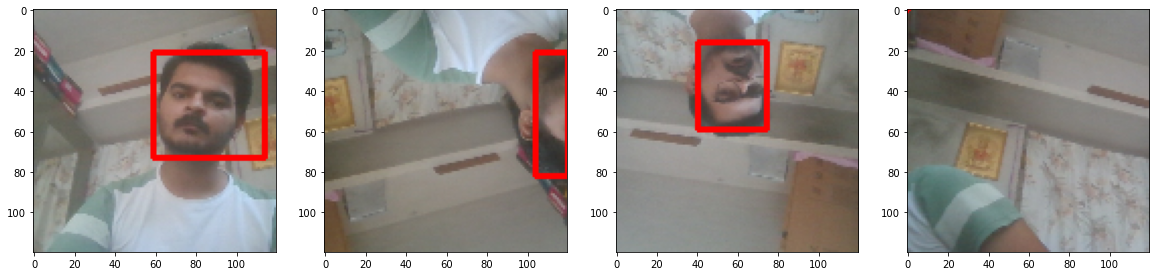

In [73]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Build Deep Learning using the Functional API

### Import Layers and Base Network

In [74]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#### Download VGG16

In [75]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 7s 0us/step


In [76]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Build instance of Network

In [77]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## Test out Neural Network

In [78]:
facetracker = build_model()

In [79]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [80]:
X, y = train.as_numpy_iterator().next()

In [81]:
X.shape

(8, 120, 120, 3)

In [82]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [83]:
classes, coords

(array([[0.48188293],
        [0.54795194],
        [0.48385105],
        [0.49183124],
        [0.52840674],
        [0.4999862 ],
        [0.4711411 ],
        [0.5464373 ]], dtype=float32),
 array([[0.38900492, 0.44541132, 0.33396253, 0.63140786],
        [0.37665606, 0.39615744, 0.29539993, 0.5042103 ],
        [0.4415873 , 0.4763318 , 0.45496234, 0.546056  ],
        [0.40559766, 0.40729985, 0.4293135 , 0.4959178 ],
        [0.41706562, 0.38283154, 0.32251695, 0.5649518 ],
        [0.40928224, 0.37845635, 0.42756227, 0.47292584],
        [0.4015455 , 0.40124908, 0.41770235, 0.5344525 ],
        [0.4197662 , 0.4029704 , 0.31058815, 0.50060993]], dtype=float32))

## Define Losses and Optimizers

In [84]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [85]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## Create Localization Loss and Classification Loss

In [86]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [87]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Test out Loss Metrics

In [88]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.737029>

In [89]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6552943>

In [90]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.737029>

# Train Neural Network

## Create Custom Model Class

In [91]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [92]:
model = FaceTracker(facetracker)

In [93]:
model.compile(opt, classloss, regressloss)

## Train

In [94]:
logdir='logs'

In [95]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [96]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
465/465 [==============================] - 1818s 4s/step - total_loss: 0.2818 - class_loss: 0.0924 - regress_loss: 0.2355 - val_total_loss: 0.0887 - val_class_loss: 0.0095 - val_regress_loss: 0.0839
Epoch 2/10
465/465 [==============================] - 1437s 3s/step - total_loss: 0.1146 - class_loss: 0.0436 - regress_loss: 0.0928 - val_total_loss: 0.0969 - val_class_loss: 0.0031 - val_regress_loss: 0.0954
Epoch 3/10
465/465 [==============================] - 1273s 3s/step - total_loss: 0.0468 - class_loss: 0.0141 - regress_loss: 0.0398 - val_total_loss: 0.0535 - val_class_loss: 2.3382e-04 - val_regress_loss: 0.0533
Epoch 4/10
465/465 [==============================] - 1281s 3s/step - total_loss: 0.0362 - class_loss: 0.0137 - regress_loss: 0.0293 - val_total_loss: 0.0670 - val_class_loss: 8.3001e-04 - val_regress_loss: 0.0666
Epoch 5/10
465/465 [==============================] - 1270s 3s/step - total_loss: 0.0235 - class_loss: 0.0081 - regress_loss: 0.0194 - val_total_loss: 0

##  Plot Performance

In [97]:
hist.history

{'total_loss': [0.03348656743764877,
  0.024800989776849747,
  0.015877213329076767,
  0.0069898078218102455,
  0.003923810087144375,
  0.006360377185046673,
  0.004760893527418375,
  0.004734030459076166,
  0.01394475158303976,
  0.0025139772333204746],
 'class_loss': [0.0023612938821315765,
  0.007196315098553896,
  0.0029136312659829855,
  0.000929428031668067,
  0.0002174640540033579,
  0.0005880043026991189,
  5.602817691396922e-05,
  0.0005214835982769728,
  3.319414099678397e-05,
  3.5042081435676664e-05],
 'regress_loss': [0.032305918633937836,
  0.021202832460403442,
  0.014420397579669952,
  0.00652509368956089,
  0.0038150781765580177,
  0.006066374946385622,
  0.004732879344373941,
  0.004473288543522358,
  0.013928154483437538,
  0.0024964562617242336],
 'val_total_loss': [0.08867426216602325,
  0.09693467617034912,
  0.05346091836690903,
  0.06699305772781372,
  0.025052068755030632,
  1.8449991941452026,
  0.02198837138712406,
  0.0640157014131546,
  0.03599053993821144,

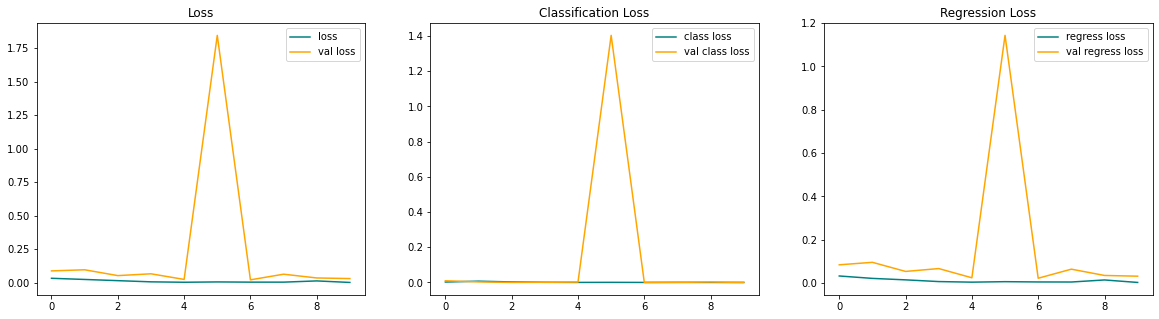

In [98]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

### Make Predictions on Test Set

In [99]:
test_data = test.as_numpy_iterator()

In [109]:
test_sample = test_data.next()

In [110]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 945ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


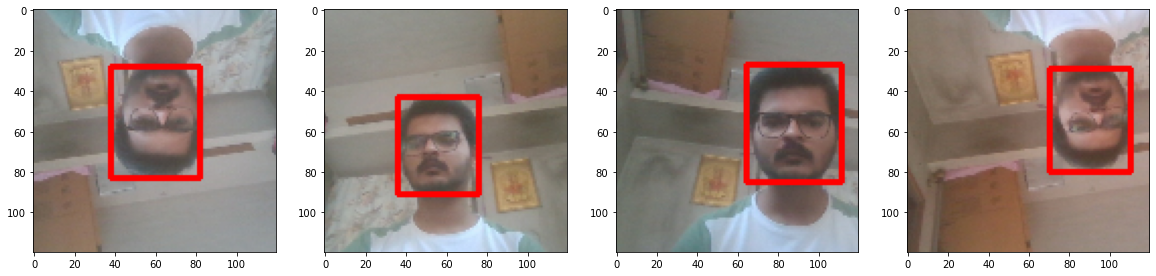

In [111]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Save the Model

In [7]:
from tensorflow.keras.models import load_model

In [11]:
import tensorflow as tf
import numpy as np

In [104]:
facetracker.save('facetracker.h5')

In [9]:
facetracker = load_model('facetracker.h5')

### Real Time Detection

In [12]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 119ms/step
